In [1]:
import librosa
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import IPython
import IPython.display as ipd  # To play sound in the notebook

In [2]:
SAMPLE_RATE = 44100
train = pd.read_csv('../input/train.csv')
train.head()

fname         label  manually_verified
0  00044347.wav        Hi-hat                  0
1  001ca53d.wav     Saxophone                  1
2  002d256b.wav       Trumpet                  0
3  0033e230.wav  Glockenspiel                  1
4  00353774.wav         Cello                  1

In [3]:
def audio_norm(data):
    max_data = np.max(np.absolute(data))
    return data/(max_data+1e-6)*0.5

In [4]:
wav, sampling_rate = librosa.core.load('../input/audio_train/'+train.fname[0], sr=16000)
wav = audio_norm(wav)
IPython.display.display(ipd.Audio('../input/audio_train/'+train.fname[0]))

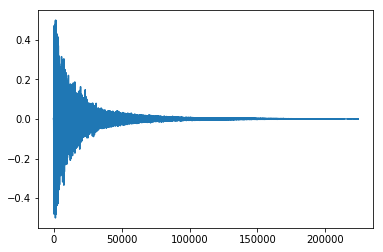

In [5]:
plt.plot(wav, '-', )

In [6]:
sampling_rate

16000

In [7]:
#pitch shift
bpo = 24 #how many steps per octave
pr = 1 #pitch shift range
ps = int(np.random.uniform(-pr * bpo, pr * bpo) + 0.5) #how many (fractional) half-steps to shift y
shifted_wav = librosa.effects.pitch_shift(wav, sampling_rate, n_steps = ps, bins_per_octave = bpo)
librosa.output.write_wav('../temp/temp.wav', shifted_wav, sampling_rate)
IPython.display.display(ipd.Audio( '../temp/temp.wav'))

In [8]:
#time stretch
tr = 2.0 #speed up/down rate
lgtr = np.log(tr)
ts = 2 ** np.random.uniform(-lgtr,lgtr)
shifted_wav = librosa.effects.time_stretch(wav, ts)
librosa.output.write_wav('../temp/temp.wav', shifted_wav, sampling_rate)
IPython.display.display(ipd.Audio( '../temp/temp.wav'))
shifted_wav

array([  4.67745960e-03,  -4.96188120e-04,  -2.55123666e-03, ...,
        -1.68712577e-05,  -1.56414972e-05,  -1.04159108e-05], dtype=float32)

In [9]:
# white noise
wnvr = 0.1 # white noise volume range
wnv  = np.random.uniform(0, wnvr) # white noise volume, random
shifted_wav = wav + np.random.uniform(-wnv, wnv, wav.shape)
librosa.output.write_wav('../temp/temp.wav', shifted_wav, sampling_rate)
IPython.display.display(ipd.Audio( '../temp/temp.wav'))
print(shifted_wav.shape)
print(wav.shape)

(224000,)
(224000,)


In [10]:
class Config(object):
    def __init__(self,
                 sampling_rate=16000, audio_duration=2, n_classes=41,
                 use_mfcc=False, n_folds=10, learning_rate=0.0001, 
                 max_epochs=50, n_mfcc=20, datagen_num = 2):
        self.sampling_rate = sampling_rate
        self.audio_duration = audio_duration
        self.n_classes = n_classes
        self.use_mfcc = use_mfcc
        self.n_mfcc = n_mfcc
        self.n_folds = n_folds
        self.learning_rate = learning_rate
        self.max_epochs = max_epochs
        self.datagen_num = datagen_num

        self.audio_length = self.sampling_rate * self.audio_duration
        if self.use_mfcc:
            self.dim = (self.n_mfcc, 1 + int(np.floor(self.audio_length/512)), 1)
        else:
            self.dim = (self.audio_length, 1)

In [11]:
def prepare_data(df, config, data_dir):
    X = np.empty(shape=(df.shape[0] * config.datagen_num, config.dim[0], config.dim[1], 1))
    y = np.empty(df.shape[0] * config.datagen_num)
    input_length = config.audio_length
    for i, fname in enumerate(df.index):
        print(fname)
        file_path = data_dir + fname
        data, _ = librosa.core.load(file_path, sr=config.sampling_rate)
        data = audio_norm(data)
        for j in range(config.datagen_num):
            #pitch shift
            bpo = 24 #how many steps per octave
            pr = 1 #pitch shift range
            ps = int(np.random.uniform(-pr * bpo, pr * bpo) + 0.5) #how many (fractional) half-steps to shift y
            shifted_data = librosa.effects.pitch_shift(data, config.sampling_rate, n_steps = ps, bins_per_octave = bpo)
            # time stretch
            tr = 2.0 #speed up/down rate
            lgtr = np.log(tr)
            ts = 2 ** np.random.uniform(-lgtr,lgtr)
            shifted_data = librosa.effects.time_stretch(shifted_data, ts)
            # white noise
            wnvr = 0.05 # white noise volume range
            wnv  = np.random.uniform(0, wnvr) # white noise volume, random
            shifted_data += np.random.uniform(-wnv, wnv, shifted_data.shape)
            # Random offset / Padding
            if len(shifted_data) > input_length:
                max_offset = len(shifted_data) - input_length
                offset = np.random.randint(max_offset)
                shifted_data = shifted_data[offset:(input_length+offset)]
            else:
                if input_length > len(shifted_data):
                    max_offset = input_length - len(shifted_data)
                    offset = np.random.randint(max_offset)
                else:
                    offset = 0
                shifted_data = np.pad(shifted_data, (offset, input_length - len(shifted_data) - offset), "constant")
            #mfcc
            shifted_data = librosa.feature.mfcc(shifted_data, sr=config.sampling_rate, n_mfcc=config.n_mfcc)
            shifted_data = np.expand_dims(shifted_data, axis=-1)
            X[ i * config.datagen_num + j, :] = shifted_data
            y[ i * config.datagen_num + j] = df.label_idx[i]
    return X, y

In [12]:
config = Config(sampling_rate=44100, audio_duration=2, n_folds=5, 
                learning_rate=0.001, use_mfcc=True, n_mfcc=40, datagen_num=3)
train = pd.read_csv("../input/train.csv")
LABELS = list(train.label.unique())
label_idx = {label: i for i, label in enumerate(LABELS)}
train.set_index("fname", inplace=True)
train["label_idx"] = train.label.apply(lambda x: label_idx[x])

In [13]:
X_train, y = prepare_data(train, config, '../input/audio_train/')

00044347.wav
001ca53d.wav
002d256b.wav
0033e230.wav
00353774.wav
003b91e8.wav
003da8e5.wav
0048fd00.wav
004ad66f.wav
0063ab88.wav
006f2f32.wav
0075d39c.wav
00780200.wav
0079d310.wav
0091fc7f.wav
0097160c.wav
00ad7068.wav
00c5808a.wav
00c82919.wav
00c934d7.wav
00c9e799.wav
00cb787c.wav
00ce569f.wav
00d1fe46.wav
00d3bba3.wav
00d40fa2.wav
00d9fa61.wav
00e2b4cd.wav


KeyboardInterrupt: 

In [ ]:
np.save('X_train.npy',X_train)
np.save('y.npy',y)